<a href="https://colab.research.google.com/github/rmontenegroo/discursos/blob/main/nlp_discursos_camara_classficador_por_genero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gensim==4.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 134.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import numpy as np
import random
import os
import string
import nltk
import gensim
import keras as tf
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from google.colab import drive

from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from gensim.models import Word2Vec
from keras.preprocessing import text, sequence
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Reshape
from imblearn.under_sampling import RandomUnderSampler

nltk.download('punkt')

tf.device('/device:GPU:0')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
RANDOM_SEED = 12
MAX_FEATURES = 50000
EMBEDDINGS_DIM = 100

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

ROOTDIR = '/content/drive/MyDrive/Pós/discursos/'

from google.colab import drive
drive.mount('/content/drive')

LEGISLATURA = 56
TEST_SIZE = 0.2

Mounted at /content/drive


In [ ]:
discursos = pd.DataFrame()
with open(ROOTDIR + f'data/tokens_{LEGISLATURA}.dat', 'rb') as fp:
    discursos = pickle.load(fp)

discursos = discursos.join(pd.read_json(ROOTDIR + 'data/detalhes_deputados.json'), on=['idDeputado'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


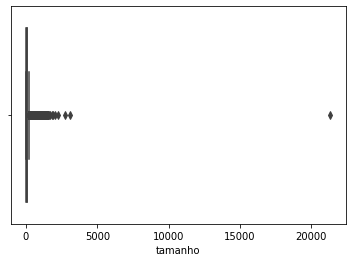

In [ ]:
discursos['tamanho'] = discursos.tokens_.map(len)
sns.boxplot(discursos.tamanho) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


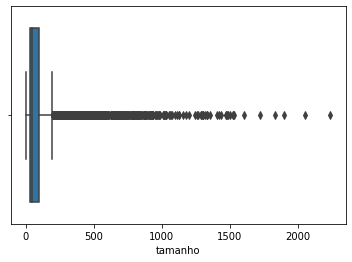

In [ ]:
# descartar discursos muito grandes
MAX_TAM = 2500
discursos = discursos.loc[discursos.tamanho <= MAX_TAM]
sns.boxplot(discursos.tamanho)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


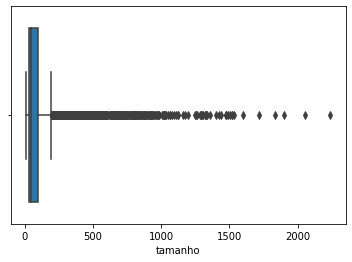

In [ ]:
# descartar discursos muito curtos
MIN_TAM = 10
discursos = discursos.loc[discursos.tamanho >= MIN_TAM]
sns.boxplot(discursos.tamanho)

In [ ]:
discursos.sexo.value_counts()

M    45563
F    12641
Name: sexo, dtype: int64

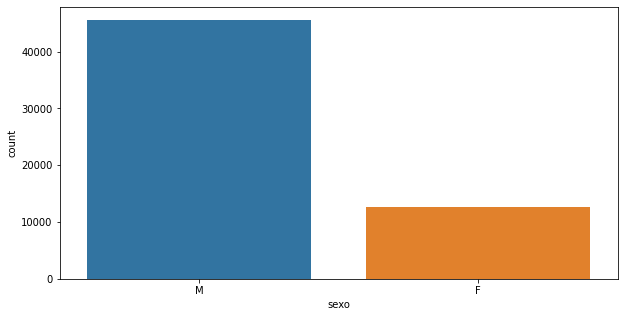

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x = 'sexo' , data = discursos, order = ('M', 'F'))
plt.show()

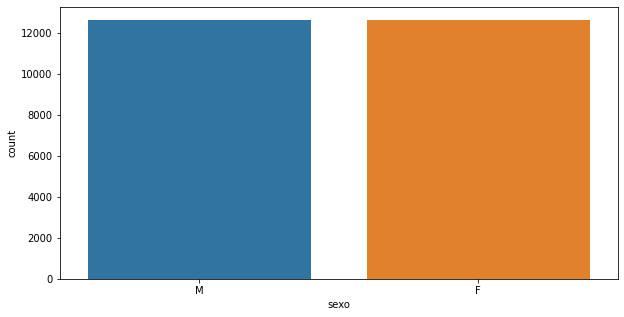

In [ ]:
rus = RandomUnderSampler(random_state=RANDOM_SEED)
discursos, y = rus.fit_resample(discursos, discursos['sexo'])

plt.figure(figsize=(10, 5))
sns.countplot(x = 'sexo' , data = discursos, order = ('M', 'F'))
plt.show()

In [ ]:
df_treino, df_teste = train_test_split(discursos, test_size=TEST_SIZE, random_state=RANDOM_SEED)

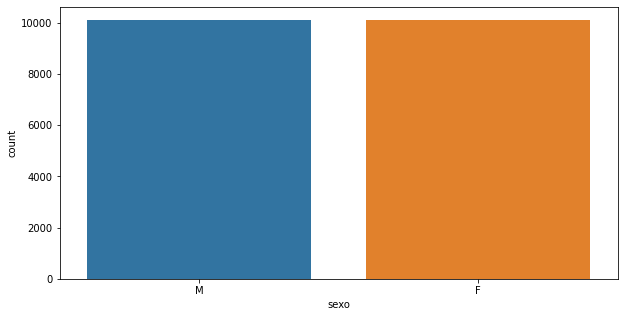

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'sexo' , data = df_treino, order = ('M', 'F'))
plt.show()

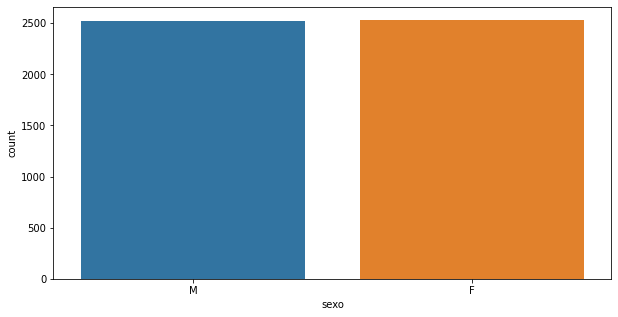

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'sexo' , data = df_teste, order = ('M', 'F'))
plt.show()

In [ ]:
tokenizer = text.Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(discursos['tokens'])

labeler = LabelEncoder()
labeler.fit(discursos['sexo'])

LabelEncoder()

In [ ]:
# discursos = None
# detalhes = None

In [ ]:
X_treino = df_treino['tokens']
X_teste = df_teste['tokens']

MAX_DOC_LEN = np.max((X_teste.map(len).max(), X_treino.map(len).max()))

X_treino = tokenizer.texts_to_sequences(X_treino)
X_treino = sequence.pad_sequences(X_treino, maxlen=MAX_DOC_LEN)

X_teste = tokenizer.texts_to_sequences(X_teste)
X_teste = sequence.pad_sequences(X_teste, maxlen=MAX_DOC_LEN)

In [ ]:
Y_treino = df_treino['sexo']
Y_teste = df_teste['sexo']

Y_treino = to_categorical(labeler.transform(Y_treino), 2, dtype='float32')
Y_teste = to_categorical(labeler.transform(Y_teste), 2, dtype='float32')

In [ ]:
w2v = Word2Vec.load(ROOTDIR + f'camares.{EMBEDDINGS_DIM}.w2v')

embeddings_mean, embeddings_std = w2v.wv.vectors.mean(), w2v.wv.vectors.std()

embeddings_matrix = np.random.normal(embeddings_mean, embeddings_std, size=(MAX_FEATURES, EMBEDDINGS_DIM))

for word, i in tokenizer.word_index.items():
    if i >= MAX_FEATURES: continue
    try:
      embeddings_matrix[i] = w2v.wv[word]
    except KeyError:
      pass

In [ ]:
BATCH_SIZE = 200
EPOCHS = 50
PATIENCE_LR = 5
PATIENCE_ES = 2
FACTOR = 0.25
MIN_LR = 0.00000001
PLATEAU_MONITOR = 'val_categorical_crossentropy'
LSTM_LAYER1_SIZE = 32
LSTM_LAYER2_SIZE = 32
LAYER1_DROPOUT_RATE = 0.5
LAYER2_DROPOUT_RATE = 0.25
RECURRENT_DROPOUT_RATE = 0.2
DENSE_LAYER1_SIZE = 16
# DENSE_LAYER1_DROPOUT_RATE = 0.5
DENSE_LAYER2_SIZE = 16
# DENSE_LAYER2_DROPOUT_RATE = 0.25
DENSE_LAYER1_FUNCTION = 'relu'
DENSE_LAYER2_FUNCTION = 'relu'
OUTPUT_LAYER_SIZE = 2
OUTPUT_LAYER_FUNCTION = 'softmax'
LEARNING_RATE = 0.01
OPTIMIZER = tf.keras.optimizers.Adam
LOSS_FUNCTION = 'categorical_crossentropy'
METRIC_FUNCTIONS = ['categorical_accuracy', 'categorical_crossentropy']
# VALIDATION_SPLIT_RATE = 0.2
VALIDATION_SPLIT_RATE = 0.1

model = Sequential()
# INPUT
model.add(Embedding(MAX_FEATURES, output_dim = EMBEDDINGS_DIM, weights = [embeddings_matrix], input_length = MAX_DOC_LEN, trainable = True))
# LSTM 
model.add(LSTM(units = LSTM_LAYER1_SIZE, return_sequences = True,  dropout = LAYER1_DROPOUT_RATE))
model.add(LSTM(units = LSTM_LAYER2_SIZE, recurrent_dropout = RECURRENT_DROPOUT_RATE, dropout = LAYER2_DROPOUT_RATE))
model.add(Dense(units = DENSE_LAYER1_SIZE, activation = DENSE_LAYER1_FUNCTION))
# model.add(Dropout(DENSE_LAYER1_DROPOUT_RATE))
model.add(Dense(units = DENSE_LAYER2_SIZE, activation = DENSE_LAYER2_FUNCTION))
# model.add(Dropout(DENSE_LAYER2_DROPOUT_RATE))
model.add(Dense(units = OUTPUT_LAYER_SIZE, activation = OUTPUT_LAYER_FUNCTION))
model.compile(optimizer = OPTIMIZER(learning_rate = LEARNING_RATE), loss = LOSS_FUNCTION, metrics = METRIC_FUNCTIONS)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8921, 100)         5000000   
                                                                 
 lstm (LSTM)                 (None, 8921, 32)          17024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 5,026,178
Trainable params: 5,026,178
Non-

In [ ]:
callbacks = [
  ReduceLROnPlateau(monitor = PLATEAU_MONITOR, patience = PATIENCE_LR, verbose = 2, factor = FACTOR, min_lr = MIN_LR),
  EarlyStopping(patience = PATIENCE_ES, verbose = True)             
]

if not os.path.isfile(ROOTDIR + f'classificador_discurso_genero_{LEGISLATURA}.dat'):

  history = model.fit(X_treino, Y_treino, batch_size = BATCH_SIZE, validation_split = VALIDATION_SPLIT_RATE, epochs = EPOCHS, callbacks = callbacks)

  with open(ROOTDIR + f'classificador_discurso_genero_{LEGISLATURA}.dat', 'wb') as fp:
    pickle.dump(model, fp)

  df_history = pd.DataFrame(history.history)
  df_history.to_json(ROOTDIR + f'data/history_classificador_discurso_genero_{LEGISLATURA}.json')

else:

  with open(ROOTDIR + f'classificador_discurso_genero_{LEGISLATURA}.dat', 'rb') as fp:
    model = pickle.load(fp)

  df_history = pd.read_json(ROOTDIR + f'data/history_classificador_discurso_genero_{LEGISLATURA}.json')

633/633 [==============================] - 1419s 2s/step - loss: 0.0296 - categorical_accuracy: 0.9944 - categorical_crossentropy: 0.0296
Acuracia de treinamento: 99.44 %
159/159 [==============================] - 357s 2s/step - loss: 0.0295 - categorical_accuracy: 0.9943 - categorical_crossentropy: 0.0295
Acuracia de teste: 99.43 %


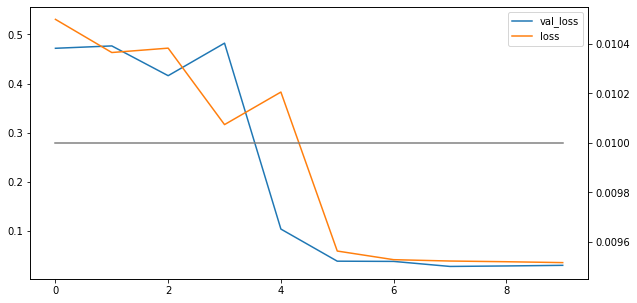

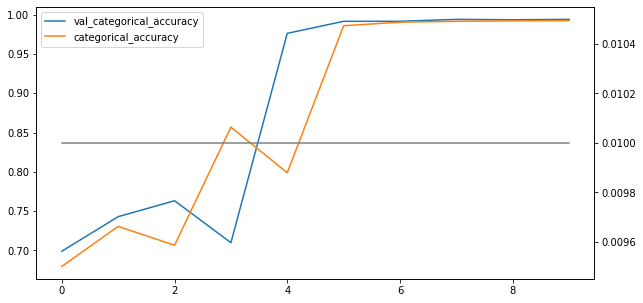

In [ ]:
ax = df_history[['val_loss', 'loss']].plot(figsize=(10, 5))
df_history['lr'].plot(ax=ax.twinx(), color='gray')

ax = df_history[['val_categorical_accuracy', 'categorical_accuracy']].plot(figsize=(10, 5))
df_history['lr'].plot(ax=ax.twinx(), color='gray')

print("Acuracia de treinamento: {:.2f} %".format(model.evaluate(X_treino, Y_treino)[1]*100))
print("Acuracia de teste: {:.2f} %".format(model.evaluate(X_teste, Y_teste)[1]*100))

In [ ]:
previsto = np.argmax(model.predict(X_teste[0:]), axis=1)

In [ ]:
previsto

array([1, 1, 1, ..., 0, 1, 1])

In [ ]:
real = np.argmax(Y_teste[0:], axis=1)

In [ ]:
real

array([1, 1, 1, ..., 0, 1, 1])

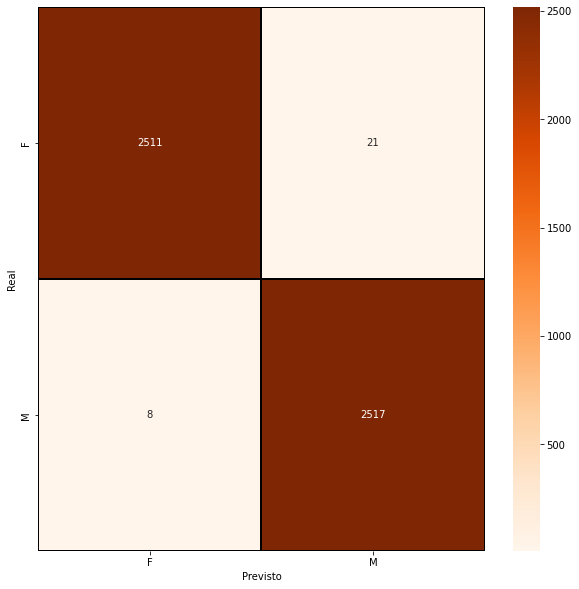

In [ ]:
cm = confusion_matrix(real, previsto)
labels = labeler.classes_
cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.figure(figsize = (10, 10))
sns.heatmap(cm, cmap= "Oranges", linecolor = 'black', linewidth = 1, annot = True, fmt='', xticklabels = labels, yticklabels = labels)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()